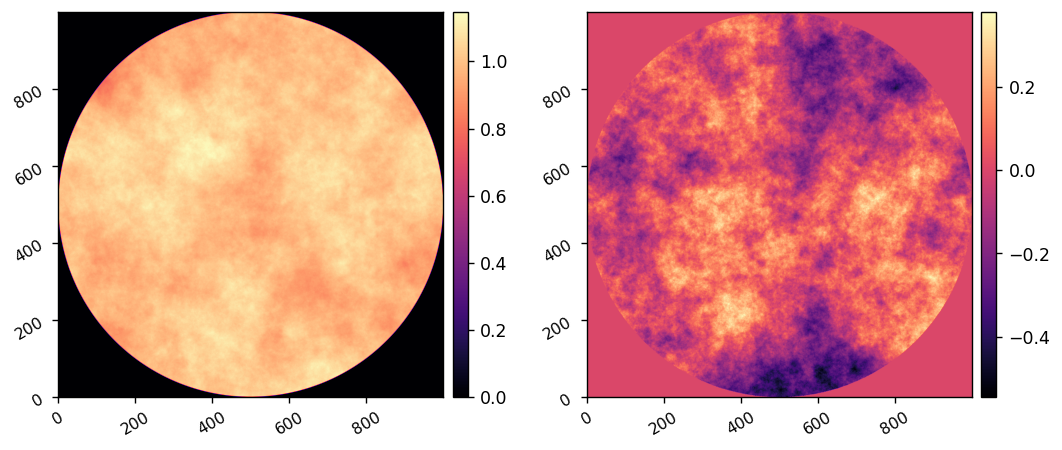

[[6.01350000e-07 6.05871429e-07 6.10392857e-07]
 [6.14914286e-07 6.19435714e-07 6.23957143e-07]
 [6.28478571e-07 6.33000000e-07 6.37521429e-07]
 [6.42042857e-07 6.46564286e-07 6.51085714e-07]
 [6.55607143e-07 6.60128571e-07 6.64650000e-07]] m


In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from importlib import reload

from scipy.optimize import minimize

import scoobpsf
import scoobpsf.scoob_rmad as rmad
import scoobpsf.props as props
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import lina
import lina.adefc_bb as adefc

wfe_amp = utils.load_fits('example_wfe_amp.fits')
wfe_phs = utils.load_fits('example_wfe_phs.fits')/2.5
WFE = wfe_amp * xp.exp(1j*wfe_phs)
imshow2(wfe_amp, wfe_phs)

Nwaves = 15
wavelength_c = 633e-9 *u.m
bw = 0.10
waves = np.linspace(wavelength_c * (1-bw/2), wavelength_c * (1+bw/2), Nwaves )
bandpasses = waves.reshape(5,3)
print(bandpasses)

# Test the forward model parameters.

Oversampling > 2x suggested for reliable results in Fresnel propagation.


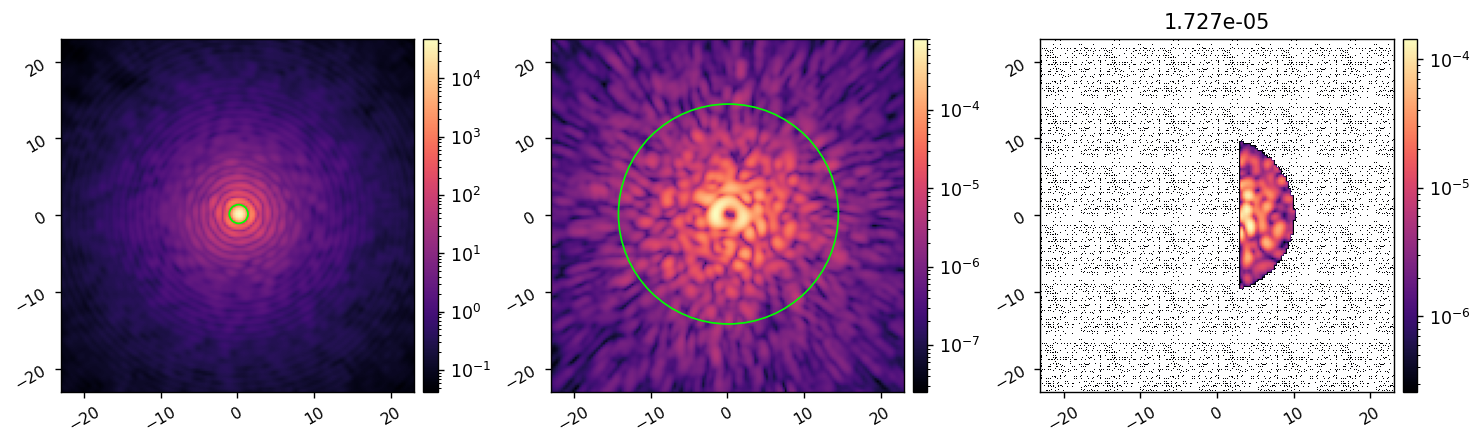

In [2]:
reload(rmad)
I = rmad.MODEL(
    dm_beam_diam=9.4*u.mm, 
    lyot_pupil_diam=9.4*u.mm,
#     dm_shift=np.array([0,0])*u.mm,
#     lyot_shift=np.array([0,0.3])*u.mm,
)
I.WFE = WFE
I.waves = waves

# I.reverse_lyot = 1
# I.flip_lyot = 1
# I.det_rotation = 178

I.setattr('use_vortex', False)
ref_psf = I.snap()
I.setattr('Imax_ref', xp.max(ref_psf))
I.setattr('use_vortex', True)
ref_coro_im = I.snap()

iwa = 3
owa = 10
rot = 0
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, irad=iwa, orad=owa, edge=iwa, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

psf_center = (I.psf_pixelscale_lamD/2, I.psf_pixelscale_lamD/2)
imshow3(ref_psf, ref_coro_im, ref_coro_im*control_mask, '', '', f'{mean_ni:.3e}',
        lognorm=True, pxscl=I.psf_pixelscale_lamD, 
        patches1=[Circle(psf_center, 1.22, fill=False, color='lime')], 
        patches2=[Circle(psf_center, I.control_rad, fill=False, color='lime')])


Oversampling > 2x suggested for reliable results in Fresnel propagation.


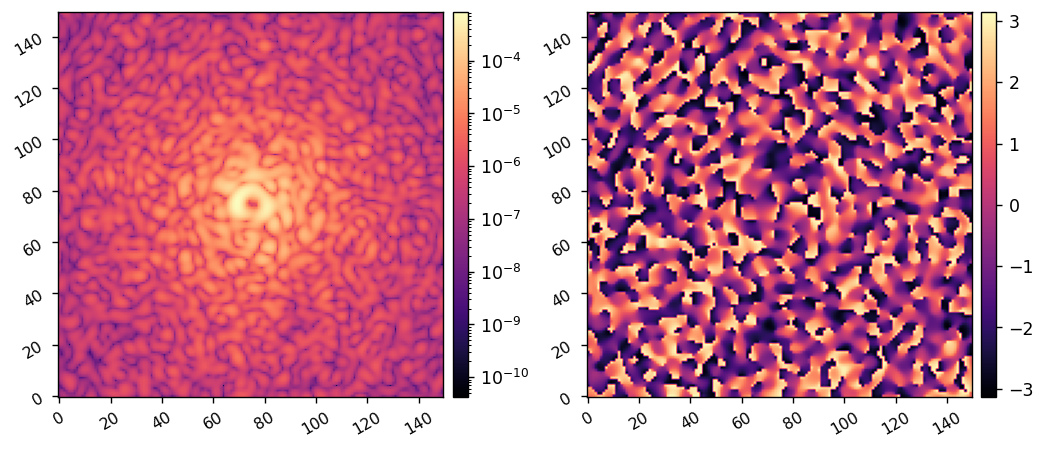

In [3]:
reload(rmad)
reload(scoobpsf.dm)
M = rmad.MODEL(
    dm_beam_diam=9.4*u.mm, 
    lyot_pupil_diam=9.4*u.mm,
    # dm_shift=np.array([0,0])*u.mm,
    # lyot_shift=np.array([0,0.3])*u.mm,
)
M.WFE = WFE

# M.reverse_lyot = 1
# M.flip_lyot = 1
# M.det_rotation = 178

M.setattr('use_vortex', False)
ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(ref_psf))

fpwf = M.forward(xp.zeros(M.dm_shape)[M.dm_mask], use_vortex=True)
imshow2(xp.abs(fpwf)**2, xp.angle(fpwf), lognorm1=True)


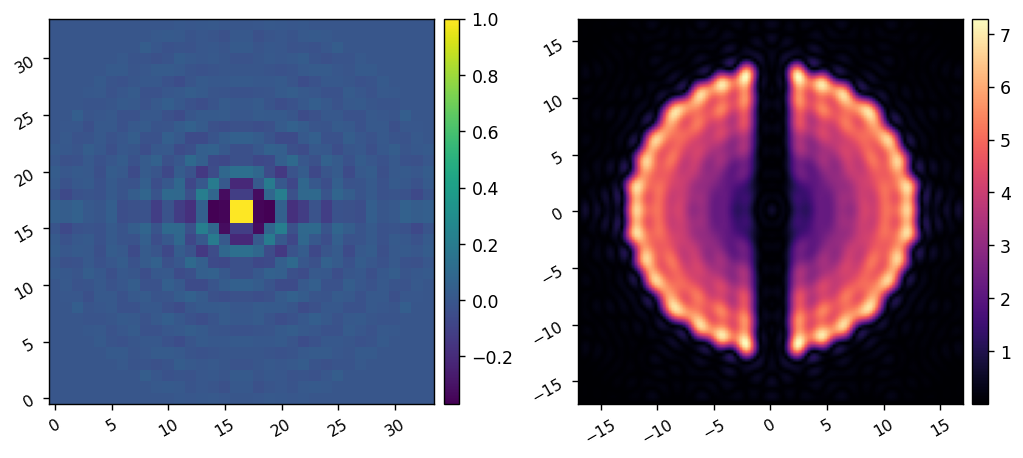

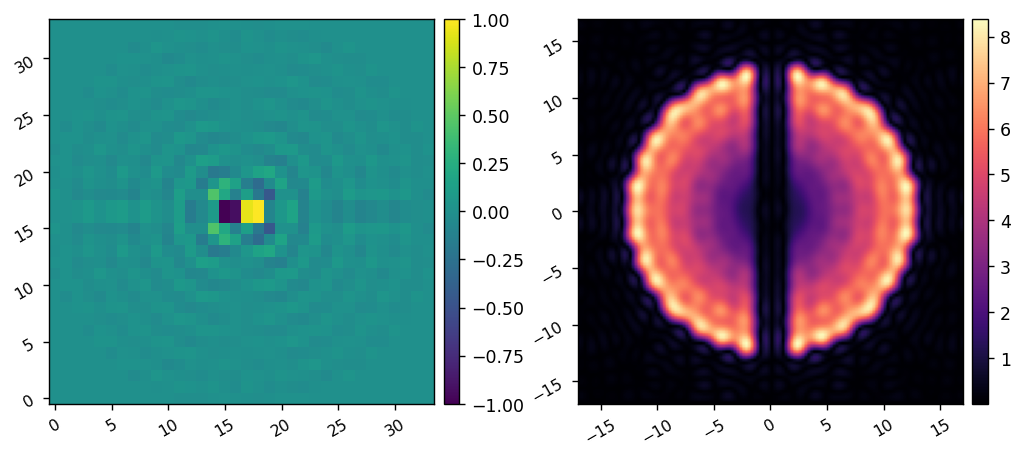

In [4]:

fourier_probes = lina.utils.create_fourier_probes(I.dm_mask, I.npsf, I.psf_pixelscale_lamD, iwa-0.5, owa+2, fourier_sampling=0.75, 
                                                    nprobes=2,
                                                    plot=True,
                                                    use_weighting=True
                                                    )

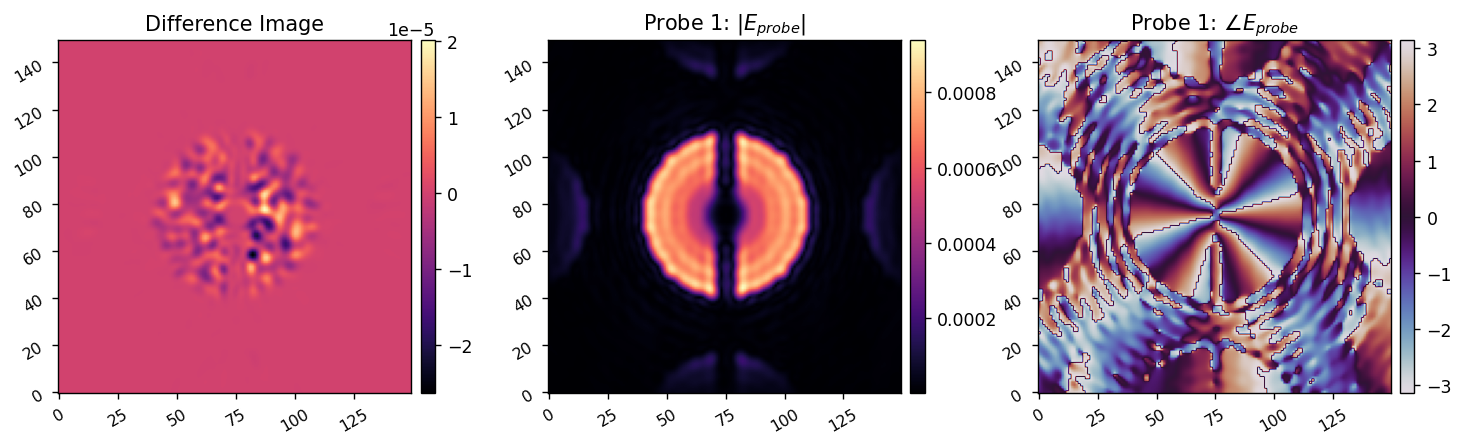

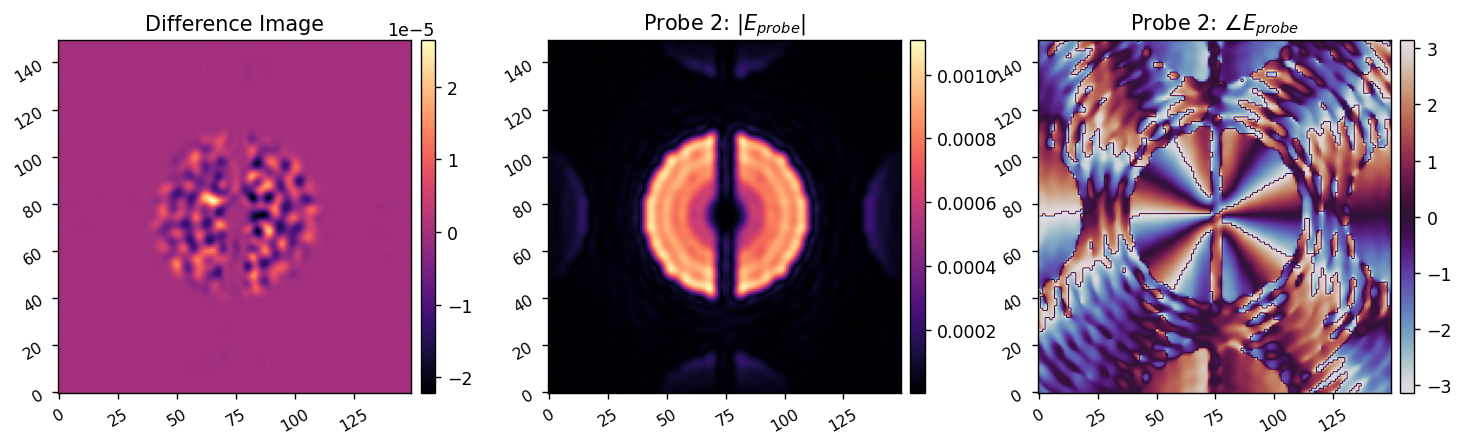

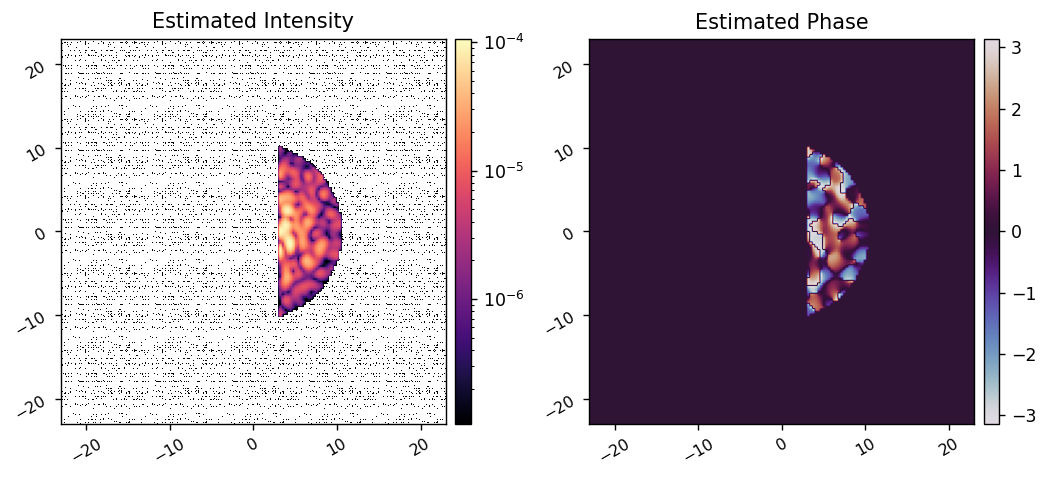

In [82]:
reload(adefc)

acts = np.zeros(I.Nacts)
# acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm(rmad.acts_to_command(acts, I.dm_mask))
E_pwp = adefc.run_pwp(I, M, I.get_dm()[M.dm_mask], control_mask, fourier_probes, 5e-9, plot=True)
I_pwp = xp.abs(E_pwp)**2
P_pwp = xp.angle(E_pwp)

In [83]:
I.zero_dm()
data = {
    # 'ref_im':ref_coro_im, 
    'images':[ref_coro_im],
    'efields':[],
    'commands':[],
    'del_commands':[],
    'reg_conds':[],
    'bfgs_tols':[],
    'pixelscale':I.psf_pixelscale_lamD,
    'control_mask':control_mask, 
}

Running estimation algorithm ...


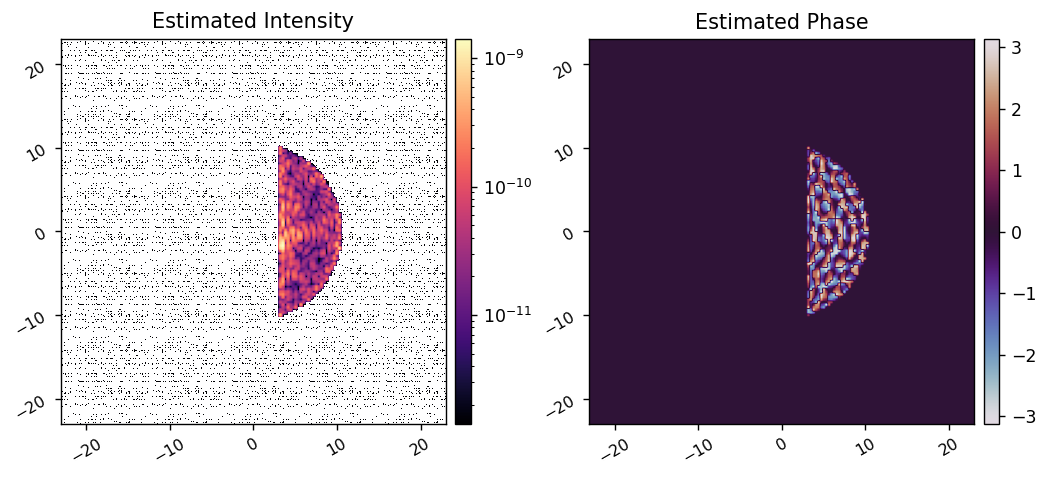

Computing EFC command with L-BFGS


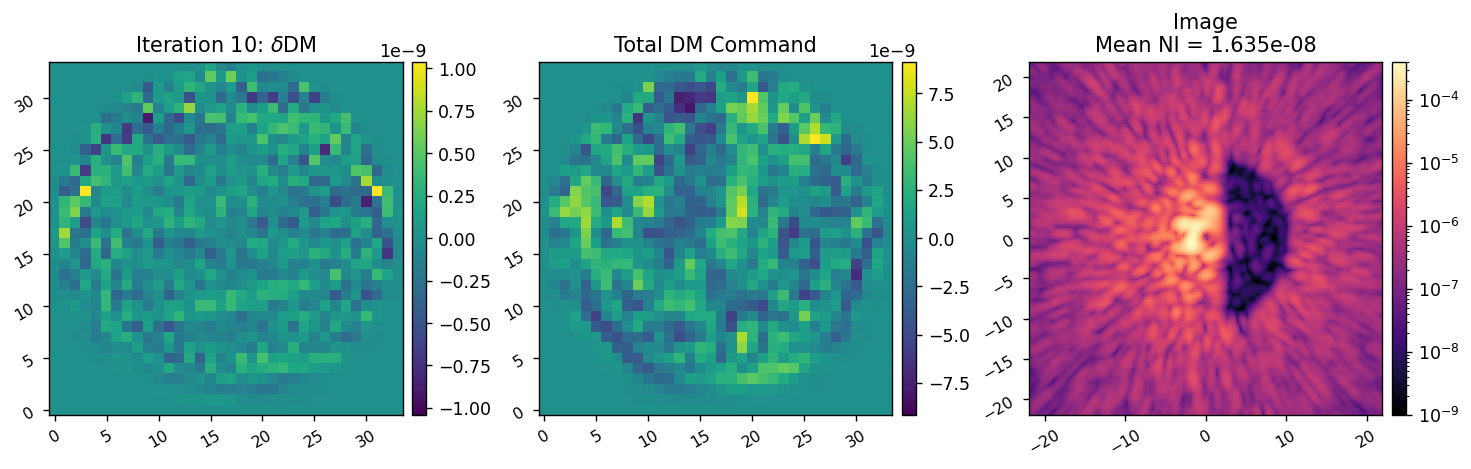

Running estimation algorithm ...


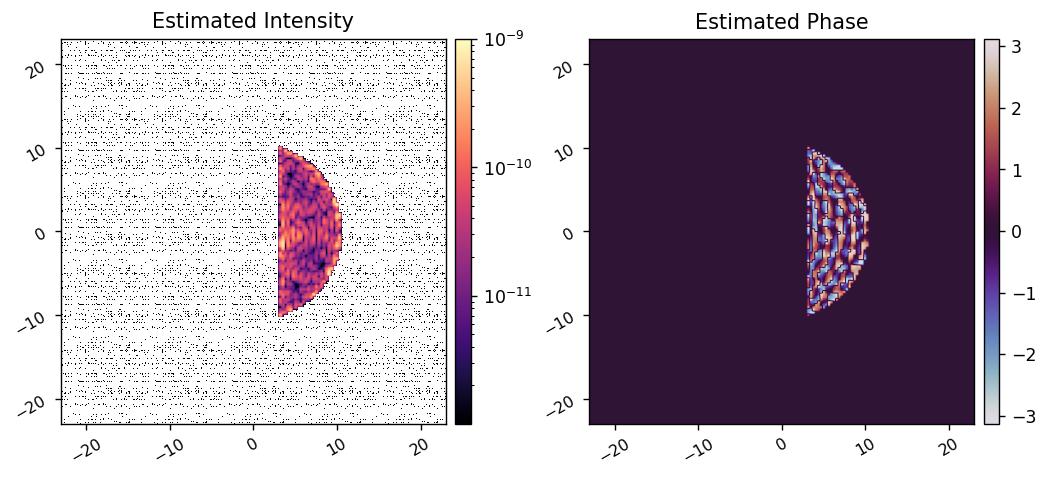

Computing EFC command with L-BFGS


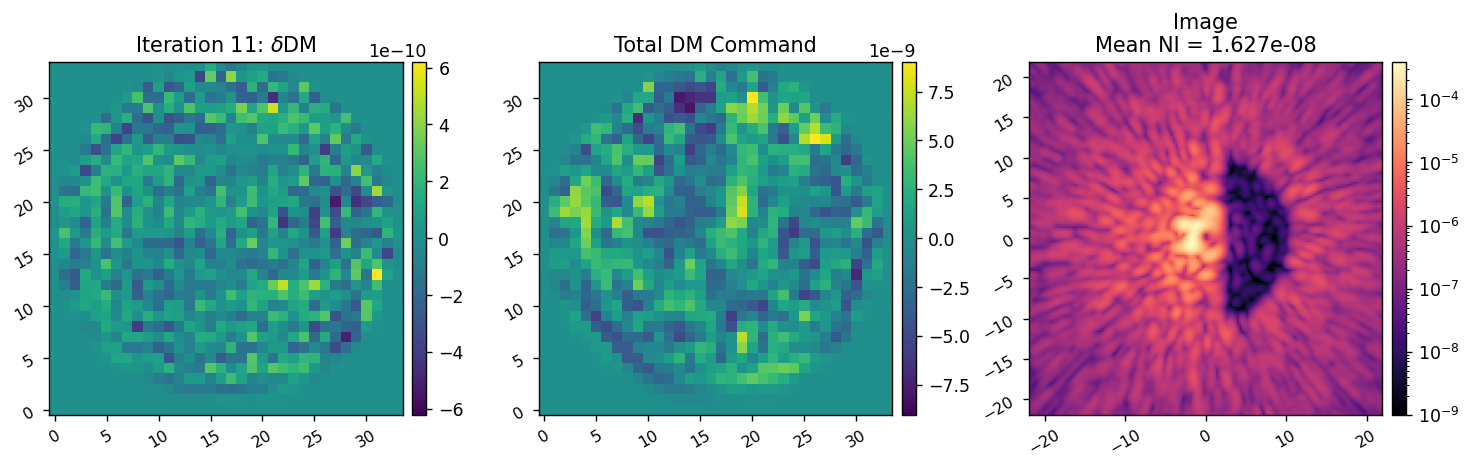

Running estimation algorithm ...


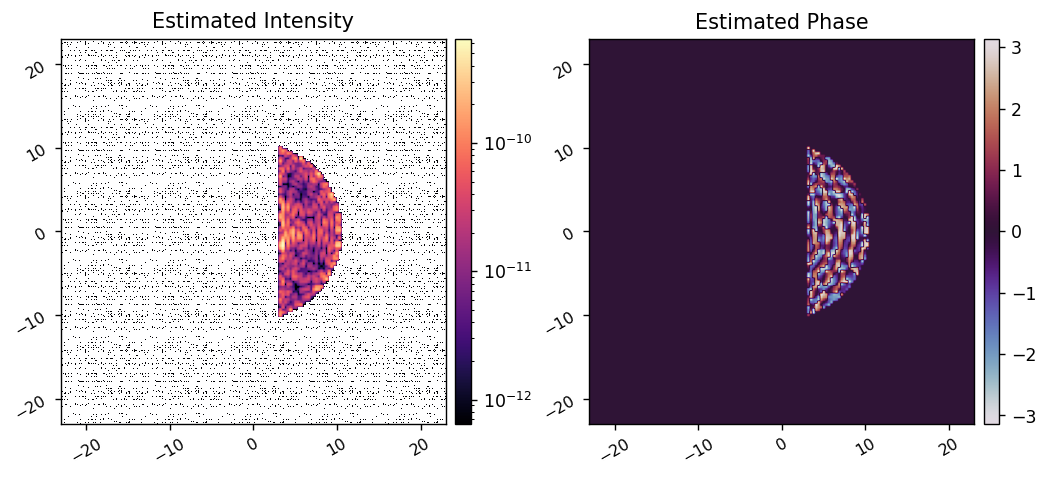

Computing EFC command with L-BFGS


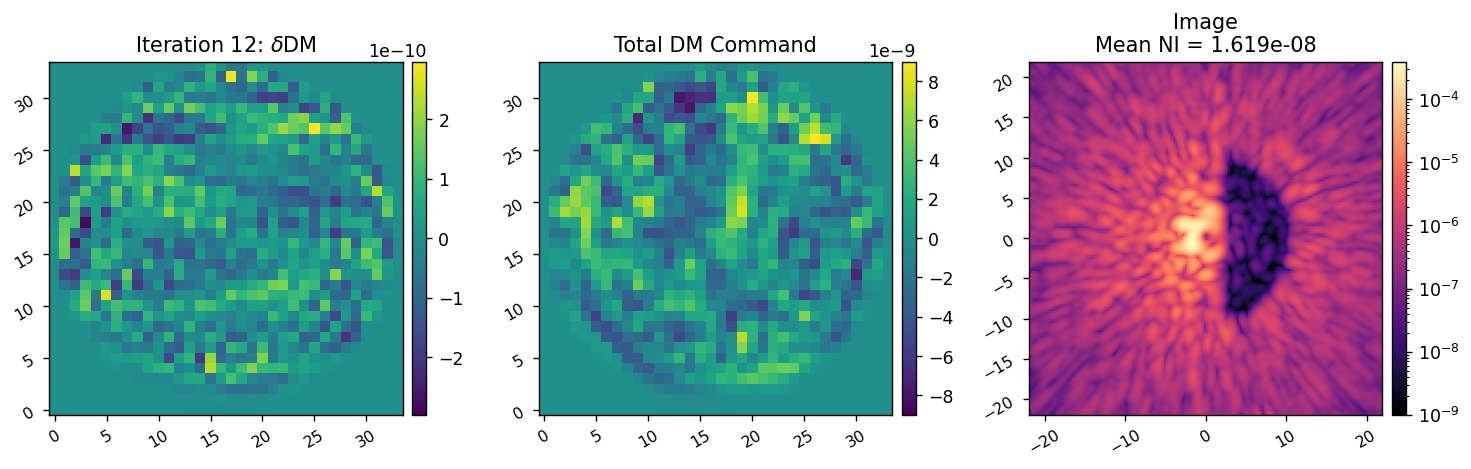

In [87]:
reload(rmad)
reload(adefc)
reload(lina.utils)

r_cond = 1e-1
r_cond = 1e-2
# r_cond = 1e-3
r_cond = 1e-4
# r_cond = 1e-5
# r_cond = 1e-6
# r_cond = 1e-15

bfgs_tol = 1e-2
bfgs_tol = 1e-3
# bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':False,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

pwp_params = {
    'control_mask':control_mask, 
    'probes':fourier_probes,
    'probe_amp':5e-9, 
    'probe_amp':2.5e-9,
    'probe_amp':1.25e-9, 
    'probe_amp':0.75e-9,
    # 'plot':True,
    'plot_est':True, 
}


data = adefc.run(I, M, 
                rmad.val_and_grad, 
                control_mask, 
                data,
                pwp_params=pwp_params, 
                Nitr=3, 
                reg_cond=r_cond,
                bfgs_tol=bfgs_tol,
                bfgs_opts=bfgs_opts,
                gain=1,
                )